# Deep learning technical model for ETFs (v3)

* Kibot etf data 
* Based on `etf_deep_learning_2020.04.30  (hankelized training)`
* Haneklized training
* Reshape the target variable to have the desired properties (such as high SR, high AC and then train with MSE against that variarlbe)
* See the Section on Loss functions in  my latex notebook
* Is accompanied by `model_v3.py`


#### NOTE : This will require rethinking the "timing" component of the factor model to use a look up tensor (like in cadre/avm work)

In [1]:
import torch as tr
tr.tensor(0) + tr.tensor(0, device='cuda')

tensor(0)

In [1]:
# preamble
%alias_magic  nbagg matplotlib -p nbagg
%alias_magic  inline matplotlib -p inline
%load_ext memory_profiler

from io import BytesIO
from IPython.display import display, Image, HTML
from pylab import *
plt.style.use( 'seaborn-whitegrid' )

from madmax.api import *
mx = mx.reload()
mxtr = mxtr.reload()

from research import yahoo; reload( yahoo)

###################################################################
# Interactive configuration 
# When running a config grid this will throw a FrozenException 
# and the grid Config will be used
###################################################################
try:
    mx.Config.name = 'etf_technical/deep_learning/2020.05.04.v3'
    mx.Config.mode = 'interactive'
    mx.Config.hps = mx.HPSet()
    mx.Config.code = 'etf_deep_learning_2020.05.04-v3.ipynb'
    disp( 'Running template configuration ', h=2 )        
except mx.Config.FrozenException:
    if mx.Config.mode != 'grid':
        raise RuntimeError( 'An unexpected configruation encountered' )
    disp( 'Running a grid configuration ', h=2 )


device = 'cuda'
dtype = tr.float32

mx.Config.start()


Created `%nbagg` as an alias for `%matplotlib nbagg`.
Created `%inline` as an alias for `%matplotlib inline`.


<IPython.core.display.Javascript object>

<h1> Config etf_technical/deep_learning/2020.05.04.v3 </h1>
<b> hash</b>: none </h4>
<b> mode </b>: interactive
<b> frozen </b>: False
<b> uri </b>: /home/fj/experiments/etf_technical/deep_learning/2020.05.04.v3/none
<h3> Hyperparameters </h3>
HPSet(
	)<h3> Code </h3>
<b> format </b>: .ipynb
<b> code </b> : /local/cloud/code/research/etf_technical/etf_deep_learning_2020.05.04-v3.ipynb

In [3]:
# --- build data ---
######################################################################################################
from research.etf_technical import load_feb2020_data as eld; reload( eld )

hps = mx.HPSet()


hps.raw_features = HPSet(
    # using adjusted prices by themselves are a bad idea
     price=['open_30min', 'high_30min', 'low_30min', 'close_30min', 
            'open_day', 'high_day', 'low_day', 'close_day', 
            'open_week', 'high_week', 'low_week', 'close_week', 
            'open_month', 'high_month', 'low_month', 'close_month', 
            'close_prev_day', 'close_prev_week' ],
    # using adjusted volumes by themselves are a bad idea
    volume = ['volume_30min', 'volume_intraday', 'volume_intraweek', 'volume_1hr', 'volume_1day'],
    # these should be ok ... but recompute using unadjusted numbers
    dollar_volume=['dollar_volume_30min', 'dollar_volume_1hr', 'dollar_volume_1day',
                   'dollar_volume_intraday', 'dollar_volume_intraweek', ],    
    calendar_features = [ 'week', 'month', 'timeofday', 'dayofweek', 'dayofmonth', 'weekofyear', 
                          'cos_timeofday', 'sin_timeofday', 
                          'cos_dayofweek', 'sin_dayofweek',
                          'cos_dayofmonth', 'sin_dayofmonth', 
                          'cos_weekofyear', 'sin_weekofyear',]
    returns_features = ['logrtn_lag_intraday', 'logrtn_lag_overnight', 'logrtn_lag_intraweek',
                        'logrtn_lag_weekend', 'logrtn_lag_intramonth', 'logrtn_lag_30min',
                        'logrtn_lag_1hr','logrtn_lag_1day', ]
    responses = ['logrtn_lead_30min',  'logrtn_lead_1hr', 'logrtn_lead_1day', 'logrtn_lead_intraday' ] 
)

@mx.memoize
def load_and_concat_data( verbose=False ):
    '''load the individual symbol files and concat them'''
    das = []
    logger = mx.Logger( 'load_and_concat_data', verbose=verbose )
    with logger.timer( 'loading the data'):
        for symbol in logger.pbar( eld.get_saved_30min_data.all_symbols ):
            if symbol.startswith( 'INCOMPLETE' ):
                logger.warn( f'No data for {symbol} - SKIPPING' )
                continue
            logger.info( 'loading data for ', symbol )
            da, meta = eld.get_saved_30min_data( symbol=symbol )
            # add a mask to indicate when this feature was valid
            da = da.assign_features( valid=da.loc[:,:,'open_30min'].isfinite() )
            das.append( da )
        da = xa.concat( das, dim='symbol' )
    # add an intercept column
    da = da.assign_features( one=1 )        
    return da


['open_30min', 'high_30min', 'low_30min', 'close_30min',
 
 
 'volume_30min',
 
       'dollar_volume_30min', 'week', 'month', 'open_day', 'high_day',
       'low_day', 'close_day', 'close_prev_day', 'open_week', 'high_week',
       'low_week', 'close_week', 'close_prev_week', 'open_month', 'high_month',
       'low_month', 'close_month', 'volume_intraday', 'volume_intraweek',
       'volume_1hr', 'volume_1day', 'dollar_volume_intraday',
       'dollar_volume_intraweek', 'dollar_volume_1hr', 'dollar_volume_1day',
       'timeofday', 'dayofweek', 'dayofmonth', 'weekofyear', 'cos_timeofday',
       'sin_timeofday', 'cos_dayofweek', 'sin_dayofweek', 'cos_dayofmonth',
       'sin_dayofmonth', 'cos_weekofyear', 'sin_weekofyear',
       'logrtn_lag_intraday', 'logrtn_lag_overnight', 'logrtn_lag_intraweek',
       'logrtn_lag_weekend', 'logrtn_lag_intramonth', 'logrtn_lead_intraday',
       'logrtn_lag_30min', 'logrtn_lead_30min', 'logrtn_lag_1hr',
       'logrtn_lead_1hr', 'logrtn_lag_1day', 'logrtn_lead_1day', 'valid',
       'one']


da = load_and_concat_data(  )

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


In [ ]:
# --- build data ---
######################################################################################################
from research.etf_technical import load_feb2020_data as eld; reload( eld )

price_features = ['open_30min', 'high_30min', 'low_30min', 'close_30min', 
                  'open_day', 'high_day', 'low_day', 'close_day', 'close_prev_day', 
                  'open_week', 'high_week', 'low_week', 'close_week', 'close_prev_week', 
                  'open_month', 'high_month', 'low_month', 'close_month', ]
                      
volume_features = ['volume_30min', 'volume_intraday', 'volume_intraweek', 'volume_1hr', 'volume_1day', 
                       'dollar_volume_30min', 'dollar_volume_intraday',
                       'dollar_volume_intraweek', 'dollar_volume_1hr', 'dollar_volume_1day',]
                       
calendar_features = [ 'week', 'month', 'timeofday', 'dayofweek', 'dayofmonth', 
                          'weekofyear', 'cos_timeofday', 'sin_timeofday', 
                          'cos_dayofweek', 'sin_dayofweek', 'cos_dayofmonth',
                          'sin_dayofmonth', 'cos_weekofyear', 'sin_weekofyear',]

returns_features = ['logrtn_lag_intraday', 'logrtn_lag_overnight', 'logrtn_lag_intraweek',
                    'logrtn_lag_weekend', 'logrtn_lag_intramonth', 'logrtn_lag_30min',
                    'logrtn_lag_1hr','logrtn_lag_1day', ]

responses = ['logrtn_lead_30min',  'logrtn_lead_1hr', 'logrtn_lead_1day'] #'logrtn_lead_intraday', 


@mx.memoize
def load_and_concat_data( verbose ):
    '''load the individual symbol files and concat them'''
    das = []
    logger = mx.Logger( 'load_and_concat_data', verbose=verbose )
    with logger.timer( 'loading the data'):
        for symbol in logger.pbar( eld.get_saved_30min_data.all_symbols ):
            if symbol.startswith( 'INCOMPLETE' ):
                logger.warn( f'No data for {symbol} - SKIPPING' )
                continue
            logger.info( 'loading data for ', symbol )
            da, meta = eld.get_saved_30min_data( symbol=symbol )
            # add a mask to indicate when this feature was valid
            da = da.assign_features( valid=da.loc[:,:,'open_30min'].isfinite() )
            das.append( da )
        da = xa.concat( das, dim='symbol' )
    # add an intercept column
    da = da.assign_features( one=1 )        
    return da

@mx.operatorize( memoize='md', consumes_features=False, produces_meta=True )
def FeatureBuilder( data, responses=responses,  ema=True, equalize_lagging_returns=False,
                    haar=False, dilation=2, levels=5, winsorize=0.05, smz=False, xsz=False,
                    volume_features=volume_features, returns_features=returns_features,
                    verbose=False ):
    '''
    build up the 30 min dataset for learning
    
    equalize_lagging_returns:
        divide out annual vol from all lagging returns features
        Leading returns features are equalized anyways
    '''
    INTS_PER_DAY = 13
    logger = mx.Logger( 'build_features', verbose=verbose )
    da = load_and_concat_data( verbose=verbose )
    features = volume_features + returns_features
    
    with logger.timer( ' compute log features' ):
        for ft in ['dollar_volume_30min', 'open_30min', 'dollar_volume_intraday',  'dollar_volume_intraweek',] :
            da = da.assign_features( **{ f'log_{ft}': da.loc[:,:, ft].log() } )
            features.append( f'log_{ft}' )
    
    with logger.timer(' compute annual returns volatility'):
        annual_vol = 'logrtn_lag_30min_annual_vol'
        avc = mx.transforms.rolling( windows='252D', sid='symbol', min_periods=INTS_PER_DAY*60 ).sd()
        da = avc( da, features='logrtn_lag_30min' ).rename_coords( features={avc.output_features[0]: annual_vol} )        
        # equalize the response variable
        equalized_responses = []
        for response in responses:
            equalized_response = f'{response}_equalized'
            da = da.assign_features( **{equalized_response: da.loc[:,:,response] / ( da.loc[:,:,annual_vol] + 1e-12 ) } )
            equalized_responses.append( equalized_response )
    
    if equalize_lagging_returns:
        # equalize all the laggign returns columns inplace ....
        with logger.timer( 'compute "normalized" leading and lagging returns' ):
            da.loc[:,:,returns_features] =  da.loc[:,:,returns_features] / ( da.loc[:,:,annual_vol] + 1e-12 )
   
    with logger.timer('computing market betas and market return '):
        da = da.assign_features( 
            mkt_logrtn_lag_30min=da.loc[:,'SPY', 'logrtn_lag_30min'],
            mkt_logrtn_lag_1day=da.loc[:,'SPY', 'logrtn_lag_1day'],
            mkt_logrtn_lead_30min=da.loc[:,'SPY', 'logrtn_lead_30min'],
            mkt_logrtn_lead_1day=da.loc[:,'SPY', 'logrtn_lead_1day'], 
        )
        beta_da, beta_features = mx.compute_betas( da, sid_rtn='logrtn_lag_30min', factor_rtn='mkt_logrtn_lag_30min',  
                                                   halflifes=[13*90, 13*180, 13*252]  )
        da = da.assign_features( betas=beta_da )            
    with logger.timer( 'residualizing returns for tilt and beta'):
        residualizer = (mx.transforms.returns( sid='symbol' )
                        .residualize( 
                            response=responses+['logrtn_lag_30min', 'logrtn_lag_1day'], 
                            updater=mx.LinearUpdater( loss='l2', ridge=1e-12, algo='direct', hl_1='10D', hl_2='10D' ) 
                        )
                        .set( verbose=verbose ))
        dao = residualizer( da.fillna(0), features=['one'] + beta_features )
        resid_features = residualizer.output_features
        # this step is because of the blanket fillna in the residualizer
        da = xa.concat( [da, dao.loc[:,:, resid_features] ], dim='features' )
        features += mx.Features('/.*lag.*/').find( resid_features )

        # plot rolling correlation before and after residualization
        def _roll_corr( X, Y, win=10*13 ):
            XY = ( X * Y ).rolling(time=win).mean( )
            Xs = X.sq().rolling( time=win ).mean()
            Ys = Y.sq().rolling( time=win ).mean()
            XYc = 100 * XY.mean( dim='symbol' ) / (Xs.mean( dim='symbol' ).sqrt() + 1e-13) / (Ys.mean( dim='symbol' ).sqrt() + 1e-13)        
            tc = XYc.abs().mean()
            return XYc.to_series(), tc.item()

        fig1, axs = subplots( len( resid_features ), len( residualizer.features ), figsize=(20,20) )
        for i, (yorig, yresid) in enumerate( zip( residualizer.response.cols, resid_features ) ):
            for j, x in  enumerate( residualizer.features ):
                ax = axs[i][j]
                orc, oc = _roll_corr( X=da.loc[:,:,x], Y=da.loc[:,:,yorig] )
                rrc, rc = _roll_corr( X=da.loc[:,:,x], Y=da.loc[:,:,yresid] )        
                ax.plot( orc, rrc, '.', alpha=0.1 )
                ax.set_xlabel(f' {yorig} {oc:0.2f}', fontsize=15)
                ax.set_ylabel(f'{yresid} {rc:0.2f}', fontsize=15)
                ax.set_title( f'{x}', fontsize=15 )
                ax.set_xlim([-100,100])
                ax.set_ylim([-100,100])
        fig1.suptitle('correlations before and after residualization', fontsize=20 )
        fig1 = mx.fig2format( fig1 )

        fig2 = figure( figsize=(20,20))
        for i, sym in enumerate(['SPY', 'GLD', 'BND', 'HYG', 'UVXY']):
            subplot( 3, 2, i+1)
            plot( da.loc[:,sym, 'logrtn_lag_30min'].to_series().cumsum()/da.loc[:,sym, 'logrtn_lag_30min'].sum(), '-b')
            plot( da.loc[:,sym, 'logrtn_lag_30min_resid'].to_series().cumsum()/da.loc[:,sym, 'logrtn_lag_30min_resid'].sum(), '-r')
            gca().set_title(sym)        
        fig2 = mx.fig2format( fig2 )
        
    with logger.timer(' verify the results of the residualizer'):
        fact_ret =  (mx.transforms.returns( sid='symbol' )
                     .factor_returns( 
                        response=residualizer.response.cols + residualizer.output_features, 
                        updater=residualizer.updater 
                    )
                    .set( verbose=True ))
        fr_da = fact_ret( da.fillna(0), features=['one']+ beta_features )        

        fig3, axs = subplots( len( resid_features ),  len(residualizer.features), figsize=(20,20) )
        for i, (yorig, yresid) in enumerate( zip( residualizer.response.cols, resid_features ) ):
            for j, x in  enumerate( residualizer.features ):
                ax = axs[i][j]
                orig_betas = fr_da.loc[:,x,yorig]
                resid_betas = fr_da.loc[:,x,yresid]
                ax.plot( orig_betas, resid_betas, '.', alpha=0.1 )
                ax.set_xlabel(f' {yorig}', fontsize=12)
                ax.set_ylabel(f'{yresid}', fontsize=12)
        #         ax.set_title( f'{x}', fontsize=12 )
                lims = (min( orig_betas.min(), resid_betas.min() ), max( orig_betas.max(), resid_betas.max() ))
                ax.set_xlim(lims)
                ax.set_ylim(lims)        
        fig3.suptitle('betaa before and after residualization', fontsize=20 )
        fig3 = mx.fig2format( fig3 )

    if ema:
        features_to_ema = (['log_open_30min', 'log_dollar_volume_30min', 'logrtn_lag_30min', 'logrtn_lag_1day', 'mkt_logrtn_lag_1day'] 
                            + mx.Features('/.*lag.*/').find( resid_features ))
        with logger.timer( 'compute instrument volatility' ):
            emv = mx.transforms.exponential( halflifes=np.array( [2, 10, 30] ) * INTS_PER_DAY, sid='symbol' ).sd()
            da = emv( da, features=features_to_ema )
            features += emv.output_features
        with logger.timer( 'compute emas' ):
            ema = mx.transforms.exponential( halflifes=np.array( [2, 10, 30] ) * INTS_PER_DAY, sid='symbol' ).mean()
            da = ema( da, features=features_to_ema )
            features += ema.output_features

    # winsorize the features we've constructed and other good stuff
    if winsorize:
        with logger.timer( 'winsorizing' ):
            wins = mx.transforms.batch( sid='symbol' ).winsorize( quantiles=winsorize )
            wins.features = sorted( set( features + [annual_vol] ) )
            da = wins( da )
            # drop the original features and rename the winsorized one
            da = (da.drop_coords( features=wins.features )
                  .rename_coords( features=dict( zip( wins.output_features, wins.features ) ) ))

    # rolling zscore the features
    if smz:
        with logger.timer( 'rolling zscore' ):
            zscore = mx.transforms.rolling( windows=smz, sid='symbol' ).zscore()
            da = zscore( da, features=features )
            # drop the original features and rename the zscored one
            da = da.drop_coords( features=zscore.features ).rename_coords( features=dict( zip( zscore.output_features, zscore.features ) ) )
            
            
    if xsz:
        with logger.timer( 'xsz' ):
            zscore = mx.transforms.cross_sectional( sid='symbol' ).zscore()
            da = zscore( da, features=features )
            # drop the original features and rename the zscored one
            da = da.drop_coords( features=zscore.features ).rename_coords( features=dict( zip( zscore.output_features, zscore.features ) ) )
            
    meta = dict( equalized_responses=equalized_responses, annual_vol=annual_vol, beta_features=beta_features, resid_features=resid_features,
                 fig1=fig1, fig2=fig2, fig3=fig3)
    return da, features, meta


builder = FeatureBuilder( responses=responses, volume_features=volume_features, returns_features=returns_features, smz=False, verbose=True  )
builder.data = None
disp( 'expected  got', builder.hash(), h=4 )

da = builder()
disp( builder.output_meta.get('fig1') )
disp( builder.output_meta.get('fig2') )
disp( builder.output_meta.get('fig3') )

# obtain the metadata for each symbol
metas = []
for symbol in da.symbol.values:
    for etf_list in [eld.bond_etfs, eld.equity_etfs, eld.vol_etfs]:
        if symbol in etf_list.Symbol.values:
            metas.append( etf_list[etf_list.Symbol == symbol].iloc[0].to_dict() )
            break

meta_df =pd.DataFrame(metas)     


/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )


In [21]:
%inline

# residualizer = (mx.transforms.returns( sid='symbol' )
#                 .residualize( 
#                     response=responses+['logrtn_lag_30min', 'logrtn_lag_1day'], 
#                     updater=mx.LinearUpdater( loss='l2', ridge=1e-12, algo='direct', hl_1='10D', hl_2='10D' ) 
#                 )
#                 .set( verbose=True ))
# dao = residualizer( da.fillna(0), features=['one']+ beta_features )
# resid_features = residualizer.output_features
# # this step is because of the blanket fillna in the residualizer
# dao = xa.concat( [da, dao.loc[:,:, resid_features] ], dim='features' )




# # plot rolling correlation before and after residualization
# def _roll_corr( X, Y, win=10*13 ):
#     XY = ( X * Y ).rolling(time=win).mean( )
#     Xs = X.sq().rolling( time=win ).mean()
#     Ys = Y.sq().rolling( time=win ).mean()
#     XYc = 100 * XY.mean( dim='symbol' ) / (Xs.mean( dim='symbol' ).sqrt() + 1e-13) / (Ys.mean( dim='symbol' ).sqrt() + 1e-13)        
#     tc = XYc.abs().mean()
#     return XYc.to_series(), tc.item()

# fig1, axs = subplots( len( resid_features ), len( residualizer.features ), figsize=(20,20) )
# for i, (yorig, yresid) in enumerate( zip( residualizer.response.cols, resid_features ) ):
#     for j, x in  enumerate( residualizer.features ):
#         ax = axs[i][j]
#         orc, oc = _roll_corr( X=dao.loc[:,:,x], Y=dao.loc[:,:,yorig] )
#         rrc, rc = _roll_corr( X=dao.loc[:,:,x], Y=dao.loc[:,:,yresid] )        
#         ax.plot( orc, rrc, '.', alpha=0.1 )
#         ax.set_xlabel(f' {yorig} {oc:0.2f}', fontsize=12)
#         ax.set_ylabel(f'{yresid} {rc:0.2f}', fontsize=12)
#         ax.set_title( f'{x}', fontsize=12 )
#         ax.set_xlim([-100,100])
#         ax.set_ylim([-100,100])
# fig1.suptitle('correlations before and after residualization', fontsize=20 )
# disp( fig1 )

# fig2 = figure( figsize=(20,20))
# for i, sym in enumerate(['SPY', 'GLD', 'BND', 'HYG', 'UVXY']):
#     subplot( 3, 2, i+1)
#     plot( dao.loc[:,sym, 'logrtn_lag_30min'].to_series().cumsum()/dao.loc[:,sym, 'logrtn_lag_30min'].sum(), '-b')
#     plot( dao.loc[:,sym, 'logrtn_lag_30min_resid'].to_series().cumsum()/dao.loc[:,sym, 'logrtn_lag_30min_resid'].sum(), '-r')
#     gca().set_title(sym)
# disp( fig2 )


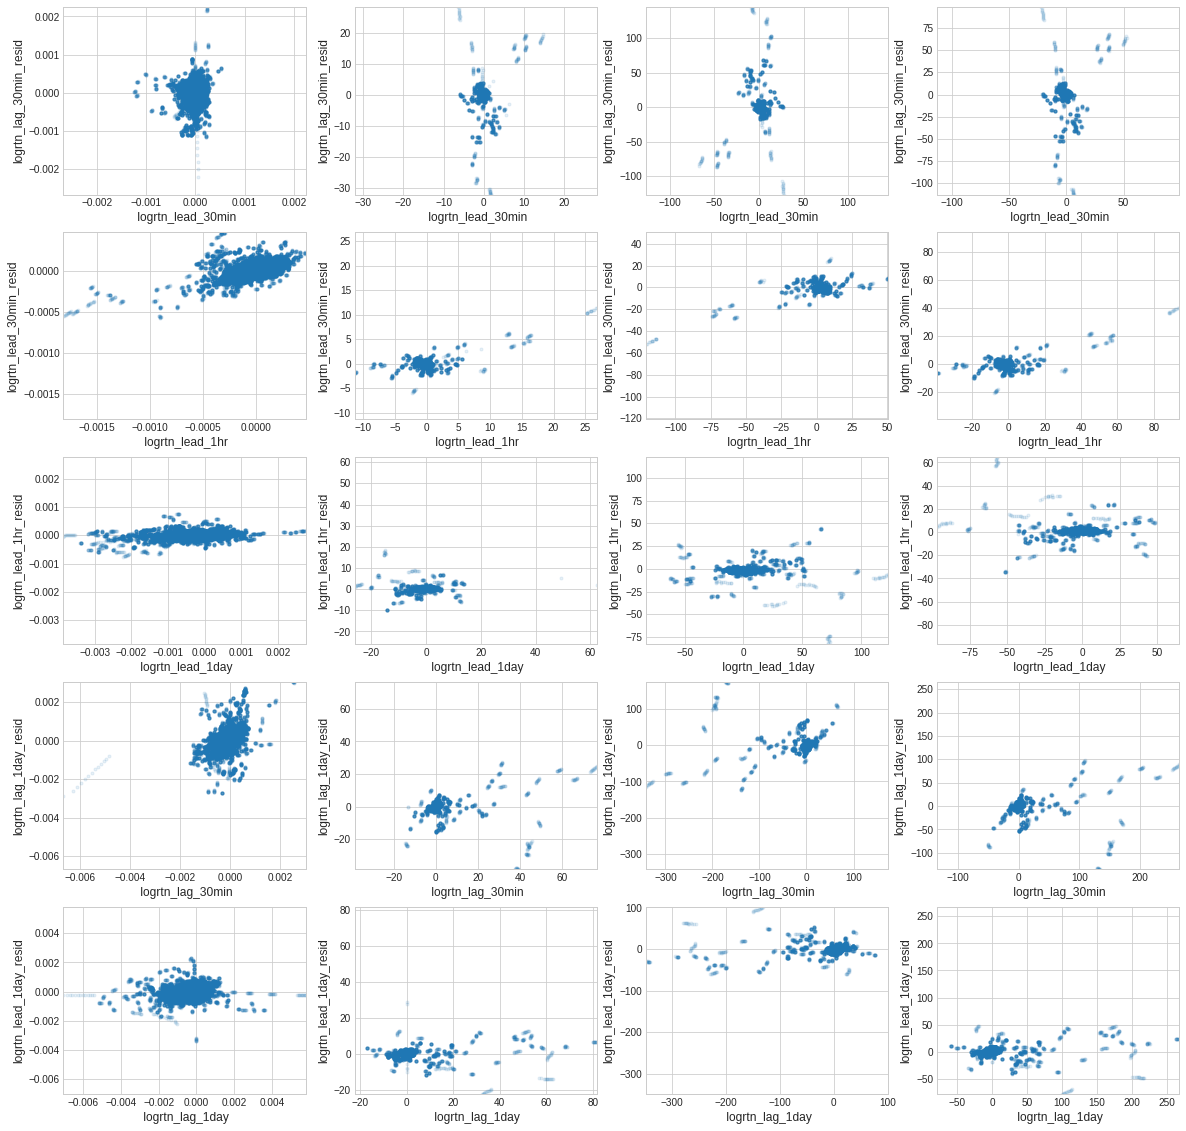

In [27]:
%inline



## Setup the training, validation and testing datasets


In [ ]:
#setup the datasets
#--------------------------------
%nbagg
mxtr = mxtr.reload() 

hps.winlen = 13 * 3 * (2 ** 5) + 512  # window lenght for haneklization (atleast more than 4 dilation levels)
hps.standardize_features = True
hps.responses = [ 'logrtn_lead_1day_equalized'] #['logrtn_lead_30min_equalized', 'logrtn_lead_1hr_equalized', 'logrtn_lead_1day_equalized'] #
hps.features =([ 
    'logrtn_lag_overnight', 'logrtn_lag_weekend', 'logrtn_lag_30min', 'logrtn_lag_1hr', 'logrtn_lag_1day',
    'logrtn_lag_intraday', 'logrtn_lag_intraweek',    'logrtn_lag_intramonth',
    'logrtn_lag_30min_26.ew_sd',  'logrtn_lag_1day_26.ew_sd',  'logrtn_lag_30min_130.ew_sd', 'logrtn_lag_1day_130.ew_sd',
    'logrtn_lag_30min_390.ew_sd', 'logrtn_lag_1day_390.ew_sd','logrtn_lag_30min_26.ew_mean', 'logrtn_lag_1day_26.ew_mean',
    'logrtn_lag_30min_130.ew_mean', 'logrtn_lag_1day_130.ew_mean','logrtn_lag_30min_390.ew_mean', 'logrtn_lag_1day_390.ew_mean',
    'log_dollar_volume_30min', 'log_dollar_volume_intraday', 'log_dollar_volume_intraweek',
    'log_dollar_volume_30min_26.ew_sd',  'log_dollar_volume_30min_130.ew_sd', 'log_dollar_volume_30min_390.ew_sd', 
    'log_dollar_volume_30min_26.ew_mean',  'log_dollar_volume_30min_130.ew_mean', 'log_dollar_volume_30min_390.ew_mean', 
    'log_open_30min', 'log_open_30min_26.ew_sd',  'log_open_30min_130.ew_sd',  'log_open_30min_390.ew_sd', 'log_open_30min_26.ew_mean', 
    'log_open_30min_130.ew_mean', 'log_open_30min_390.ew_mean', 
]) 
hps.calendar_features = ['cos_timeofday', 'sin_timeofday', 'cos_dayofweek', 'sin_dayofweek', 'cos_dayofmonth','sin_dayofmonth', 'cos_weekofyear', 'sin_weekofyear']

# convert time and sid to integers for use in pytorch
class coord_maps:
    int_to_time = pd.Series( da.time.values, index=np.arange( len( da.time ) ) )
    time_to_int = pd.Series( np.arange( len( da.time ) ),  index=da.time.values )
    int_to_sid = pd.Series( da.symbol.values, index=np.arange( len( da.symbol ) ) )
    sid_to_int = pd.Series( np.arange( len( da.symbol ) ),  index=da.symbol.values )
    
da_int = da.rename_coords( time=coord_maps.time_to_int, symbol=coord_maps.sid_to_int )
X_da = da_int.loc[:,:,hps.features + hps.calendar_features]
Y_da = da_int.loc[:,:,hps.responses]
# compute the valid-data-mask - and account for per-instrument priming in it
V_da = (da_int.loc[:,:,'valid']
        # fill small gaps
        .ffill( dim='time', limit=13*10 ) 
        # keep only the valid data for each symbol
        .notnull() ) 
V_da = ( V_da * da_int.loc[:,:,'valid'].fillna(0) )
# the weight matrix --- to do.
W_da = da_int.loc[:,:,'valid'].broadcast_like( Y_da ) 

# split the data into trg, val and testing 
hps.trg_mask = arange( 0, len( da ) // 2 )
# note adjustment for model priming
hps.val_mask = arange( hps.trg_mask.max(), int( len( da ) * 0.75 ) )
hps.tst_mask = arange( hps.val_mask.max(), len( da ) )
hps.trg_dates = pd.to_datetime( (da[hps.trg_mask].time.min().values, da[hps.trg_mask].time.max().values) )
hps.val_dates = pd.to_datetime( (da[hps.val_mask].time.min().values, da[hps.val_mask].time.max().values) )
hps.tst_dates = pd.to_datetime( (da[hps.tst_mask].time.min().values, da[hps.tst_mask].time.max().values) )


print( f'trg_fraction=', len(hps.trg_mask)/len(da), f'val_fraction=', len(hps.val_mask)/len(da), f'tst_fraction=', len(hps.tst_mask)/len(da) )

# standardize the features using the training data (non-nulls only)
if hps.standardize_features:
    X_da = (X_da - X_da[hps.trg_mask].mean( dim=['time', 'symbol'] ))  / ( X_da[hps.trg_mask].std( dim=['time', 'symbol'] ) + 1e-12)
    Y_da = (Y_da - Y_da[hps.trg_mask].mean( dim=['time', 'symbol'] ))  / ( Y_da[hps.trg_mask].std( dim=['time', 'symbol'] ) + 1e-12)
    
disp( 'X mean', X_da.mean( dim=['time', 'symbol'] ), 'std', X_da.std( dim=['time', 'symbol'] ) )
disp( 'Y mean', Y_da.mean( dim=['time', 'symbol'] ), 'std', Y_da.std( dim=['time', 'symbol'] ) )
    
# nan-fill for later processing
X_da = X_da.fillna(0)
Y_da = Y_da.fillna(0)
W_da = W_da.fillna(0)

    
# -- build the dataset objects -----
with mx.timer( 'hankeling trg'):
    trg_hankel_dataset = mxtr.HankelDataset(  
        X_da[hps.trg_mask].fillna(0), Y_da[hps.trg_mask].fillna(0), W_da[hps.trg_mask].fillna(0), 
        valid_da=V_da[hps.trg_mask], winlen=hps.winlen, min_periods=hps.winlen,
        dtype=dtype,
    )
with mx.timer( 'hankeling val'):
    val_hankel_dataset = mxtr.HankelDataset(  
        X_da[hps.val_mask].fillna(0), Y_da[hps.val_mask].fillna(0), W_da[hps.val_mask].fillna(0), 
        valid_da=V_da[hps.val_mask], winlen=hps.winlen, min_periods=hps.winlen,
        dtype=dtype,
    )    
if False:
    with mx.timer(' test the hankelization ----'):
        for self, mask in ( (trg_hankel_dataset, hps.trg_mask), (val_hankel_dataset, hps.val_mask) ):
            self.test_hankelization( X_da[mask].fillna(0), da_ix=0 )
            self.test_hankelization( Y_da[mask].fillna(0), da_ix=1 )

full_panel_dataset = mxtr.TensorDataset(
    V_da.time.broadcast_like(V_da).to_tensor( dtype=tr.int32 ),
    V_da.symbol.broadcast_like(V_da).to_tensor( dtype=tr.int32 ),
    X_da.fillna(0).to_tensor( dtype=dtype ),     
    Y_da.fillna(0).to_tensor( dtype=dtype ),  
    W_da.fillna(0).to_tensor( dtype=dtype ),  
)

tst_panel_dataset  = mxtr.TensorDataset( *full_panel_dataset[hps.tst_mask] )

## The model 

In [ ]:
# -- setup the model --
mxtr = mxtr.reload()
from research.etf_technical import model_v3 as mdl; reload(mdl)
mx.Config.start()

disp( mx.tensorboard.start( clear=True ) )
disp( mx.tensorboard.start_server() )

hps.loss_hps = mx.HPSet(
    kapow = 1e-8,
    curvature = None,
    dirichlet = None,
    lasso = None,
    lipschitz = None,
    logdet = None,
    neumann = None,
    ridge = 1e-3,
    smooth_lasso = None,
    tv = 1e-6,
    priming=13 * 3 * (2 ** 5),
    patience=1, # for logging
    error='mse',
)
mx.seed( 17 )
model = mdl.FactorResnet(     
    num_features = len( hps.features + hps.calendar_features ),
    num_responses = len( hps.responses ),
    hydra=False,
    activation = 'leaky_relu',
    batch_norm=True,
    L = 13 * 15,  # 3 day convolution kernel
    resnet_layers = 1,
    resnet_gating = False,
    resnet_channels = 10,
    dilation=2,
    monitor=True,
    loss_hps=hps.loss_hps,
).initialize( 'normal' ).to( dtype ).to( device )

desc = model.describe()
desc = desc[desc['type'] != 'Identity']
disp( desc , size=5 )

In [ ]:
# --- evaluate the untrained model ----
%inline
with mx.timer( 'predicting '):
    Yh = model.to('cpu')( X_da.to_tensor( dtype=dtype, device='cpu' ) )
    model.to( device )
Yh_da = Yh.to_dataarray( da.loc[:,:,hps.responses] )

fig = figure( figsize=(10, 10 ) )
with mx.timer( 'regressing' ):    
    reg = mx.Regression( autocorr=[1, 13, 26] )
    rms = []
    for i, (smp, mask) in pbar( enumerate( [('trg', hps.trg_mask), ('val', hps.val_mask), ('tst',hps.tst_mask), ('full', np.arange( len( Y_da ) ) ) ] ) ):
        # cut out the stuff I added to the datasets for priming
        rm = reg.regress( Yh_da[mask], da.loc[:,:,hps.responses][mask] )    
        ax = subplot( 2,2, i+1 )
        ax.plot( rm.pop('pnl').cumsum() )
        ax.set_title( smp, fontsize=15 )
        hr = rm.pop('hitRate')
        rm['sample'] = smp
        rms.append( rm )
disp( 'Untrained model ', h= 1)
disp( pd.DataFrame( rms ).set_index('sample') )
disp( fig )

In [ ]:
# -setup the learner ---
############################
mxtr = mxtr.reload()
mx.Config.start()

disp( mx.tensorboard.start( clear=True ) )
disp( mx.tensorboard.start_server() )

opt_1 = mxtr.FAdam( params=model.parameters(), lr=1e-3, betas=( 0.9, 0.99 ) ) #, tensorboard=False ) # mx.Resolve.halflife( 10)['decay'], mx.Resolve.halflife( 20 )['decay'] ) )
warmup_scheduler = mxtr.callbacks.LRSchedule(
    mxtr.WarmupAdamLR( optimizer=opt_1, min_lr=1e-4, max_lr=1e-3 ) # min_betas=(0.9,0.9), max_betas=(0.9, 0.99), T_max=500 )
)

opt_2 = mxtr.SGD( params=model.parameters(), lr=1e-5, momentum=0.9 )
cycle_scheduler = mxtr.callbacks.LRSchedule(
    mxtr.CycleAdamLR( optimizer=opt_2, min_lr=1e-5, max_lr=1e-3, T_max=200 ) #, min_betas=(0.6,0.8), max_betas=(0.9, 0.9)
)

learner = mxtr.Learner(
    optimizers=opt_1,
    trg_loss=model.trg_loss,
    val_loss=model.val_loss,    
    max_its=5000,
    device=device,
    callbacks=[
        #mxtr.callbacks.LossLogger( patience=1 ),
        mxtr.callbacks.ParameterLogger( named_params=model.named_parameters(), patience=10, grad_autocorr=False ),
        #mxtr.callbacks.ParameterEma( halflife=10, patience=5 ),
        mxtr.callbacks.ParameterMacd( hl_fast=10, hl_slow=100, patience=5, rewind_factor=None  ),
        #mxtr.callbacks.ModelSnapshots( model=model, period=100, on_minimum=True, val_halflife=10 )
        #mxtr.calllbacks.ClipGradients( dropout=0.5, signize=False, clip=None, quantile=None, winlen=100 ),
        warmup_scheduler,
        #mxtr.callbacks.SanityChecker( )
    ]    
)
disp( 'learner hash ', learner.hash(), h=4)
disp( hps )

In [ ]:
# --- do the fitting ---
#build up the trianing and validation dataloaders
hps.batch_size = 512
trg_dataloader = mxtr.DataLoader( 
    trg_hankel_dataset, batch_size=None, pin_memory=True, num_workers=12, 
    sampler=mxtr.BatchSampler( sampler=mxtr.RandomSampler( trg_hankel_dataset ), batch_size=hps.batch_size, drop_last=True )
)
val_dataloader = mxtr.DataLoader( 
    val_hankel_dataset, batch_size=None, pin_memory=True , num_workers=12,
    sampler=mxtr.BatchSampler( sampler=mxtr.RandomSampler( val_hankel_dataset ), batch_size=hps.batch_size, drop_last=True  )
    
)
for it in pbar( learner.fit_iterator( data=trg_dataloader, val_data=val_dataloader ) ) :
    continue
#     if it == 100:
#         # switch to sgd
#         learner.optimizers = [opt_2]
#         learner.callbacks.pop(-1)
#         learner.callbacks.append( cycle_scheduler.start() )

#     if it % 100 == 0:
#         tloss = model.val_loss( *[m.to(device) for m in tst_panel_dataset[:]]  )
#         disp( 'testing  loss', tloss, h=4 )
#         disp( learner.profiles.sort_values( 'duration_total', ascending=False ) )

# # run a explicit traning loop
# opt = mxtr.FAdam( params=model.parameters(), lr=1e-3, betas=( 0.9, 0.99 ), tensorboard=False ) # mx.Resolve.halflife( 10)['decay'], mx.Resolve.halflife( 20 )['decay'] ) )
# it  = 0
# for tmb, vmb in pbar( zip( trg_dataloader, val_dataloader ) ):
#     it += 1
#     tmb = [m.to(device) for m in tmb]
#     vmb = [m.to(device) for m in vmb]
#     trg_masker.restrict( tmb[0] )
#     val_masker.restrict( vmb[0] )
#     trg_mask_iterator = trg_masker.mask_iterator('trg')
#     val_mask_iterator = val_masker.mask_iterator('val')
#     opt.zero_grad()
#     trg_mask = next( trg_mask_iterator )
#     val_mask = next( val_mask_iterator )
#     tloss = trg_loss( *tmb, mask=trg_mask )
#     tloss.backward()
#     opt.step()
#     vloss = val_loss( *vmb, mask=val_mask )
#     if it % 10 == 0:
#         tloss = val_loss( *[m.to(device) for m in tst_dataset[:]]  )
#         print( 'testing  loss', tloss )


In [ ]:
# --- evaluate the Trained model ----
%inline
with mx.timer( 'predicting '):
    Yh = model.to('cpu')( X_da.to_tensor( dtype=dtype, device='cpu' ) )
    model.to( device )
Yh_da = Yh.to_dataarray( da.loc[:,:,hps.responses] )

fig = figure( figsize=(10, 10 ) )
with mx.timer( 'regressing' ):    
    reg = mx.Regression( autocorr=[1, 13, 26] )
    rms = []
    for i, (smp, mask) in pbar( enumerate( [('trg', hps.trg_mask), ('val', hps.val_mask), ('tst',hps.tst_mask), ('full', np.arange( len( Y_da ) ) ) ] ) ):
        # cut out the stuff I added to the datasets for priming
        rm = reg.regress( Yh_da[mask], da.loc[:,:,hps.responses][mask] )    
        ax = subplot( 2,2, i+1 )
        ax.plot( rm.pop('pnl').cumsum() )
        ax.set_title( smp, fontsize=15 )
        hr = rm.pop('hitRate')
        rm['sample'] = smp
        rms.append( rm )
disp( 'Trained model ', h= 1)
disp( pd.DataFrame( rms ).set_index('sample') )
disp( fig )

In [ ]:
X_da.shape

In [ ]:
# plot partial dependency
##############################################
%inline
fig = figure( figsize=(20, 20 ) )
for i in range(X_da.shape[-1]):
    subplot( 4, 4, i+1 )
    plot( X_da[:,:,i].to_series(), Yh_da.to_series() , '.', alpha=0.3 )

In [ ]:
# run a grid of hyperparameters ...
####################################

# hyperparameters
mx.Config.hps = fr.HPSet( 
  
)
mx.Config.code = ''

# configs = []
# for obs_weight in ['no_weight', 'dollar_weight', 'log_weight']:
#     cfg = fr.Config.clone()
#     cfg.hps = cfg.hps.clone( obs_weight=obs_weight )
#     cfg.freeze()
#     display_html( cfg )
#     configs.append( cfg )
# notebook = fr.Config.run_grid( configs, outfile=fr.Config.uri+'/../cadre_price_index.20200302 - weight_grid_results.ipynb', n_jobs=None )

configs = []
fr.Config.hps.obs_weight = 'log_weight'
for cbsa_factors in [5, 8, 10]:
    cfg = fr.Config.clone()
    cfg.hps = cfg.hps.clone( cbsa_factors=cbsa_factors )
    cfg.freeze()
    #display_html( cfg )
    configs.append( cfg )
notebook = fr.Config.run_grid( configs, outfile=fr.Config.uri+'/../grid_results.ipynb', n_jobs=None )


# fr.Config.hps.obs_weight = 'log_weight'
# fr.Config.hps.cbsa_factors = 8
# configs = []
# for tv in [1, 1e-1, 1e-2, 1e-3]:
#     cfg = fr.Config.clone()
#     cfg.hps = cfg.hps.clone( obs_weight=obs_weight )
#     cfg.freeze()
#     #display_html( cfg )
#     configs.append( cfg )
# notebook = fr.Config.run_grid( configs, outfile=fr.Config.uri+'/../cadre_price_index.20200302 - tv_grid_results.ipynb', n_jobs=None )




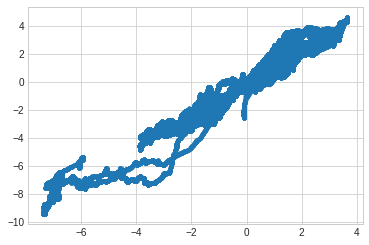

In [334]:
%inline

    
mx = mx.reload()
bda = da.assign_features( mkt_logrtn_lag_1day=bda.loc[:,'SPY', 'logrtn_lag_1day'])
betas = mx.compute_betas(  bda.loc[start:,:,:], sid_rtn='logrtn_lag_1day', factor_rtn='mkt_logrtn_lag_1day',  weight='one' )

plot( betas[0].loc[:,:,'logrtn_lag_1day_3276.ew_beta'].values.reshape(-1), mkt_beta.values.reshape(-1), '.', alpha=0.4 )

/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/cloud/code/madmax/experiment/logging.py:104: UserWarning: Logger.log_uri not set. Try running Config.start() ? Will not write to disk 
  warnings.warn( 'Logger.log_uri not set. Try running Config.start() ? Will not write to disk ' )
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


,n,finite_frac,tilt,pmSR,ic,r2,tstat,ac_1,ac_13,ac_26,ac_52
name,,,,,,,,,,,
strategy,12931474,0.694447,0.223607,8.242629,0.540608,0.292257,1.925801e+03,0.985677,0.153435,-0.014273,-0.008750
perfect,12931474,0.694447,0.078330,5.285714,1.000000,1.000000,5.320154e+07,0.917876,-0.000853,-0.022010,-0.005578
mkt beta,12931474,0.689909,0.431439,0.576126,0.030760,0.000946,9.190311e+01,1.000010,1.000108,1.000210,1.000402


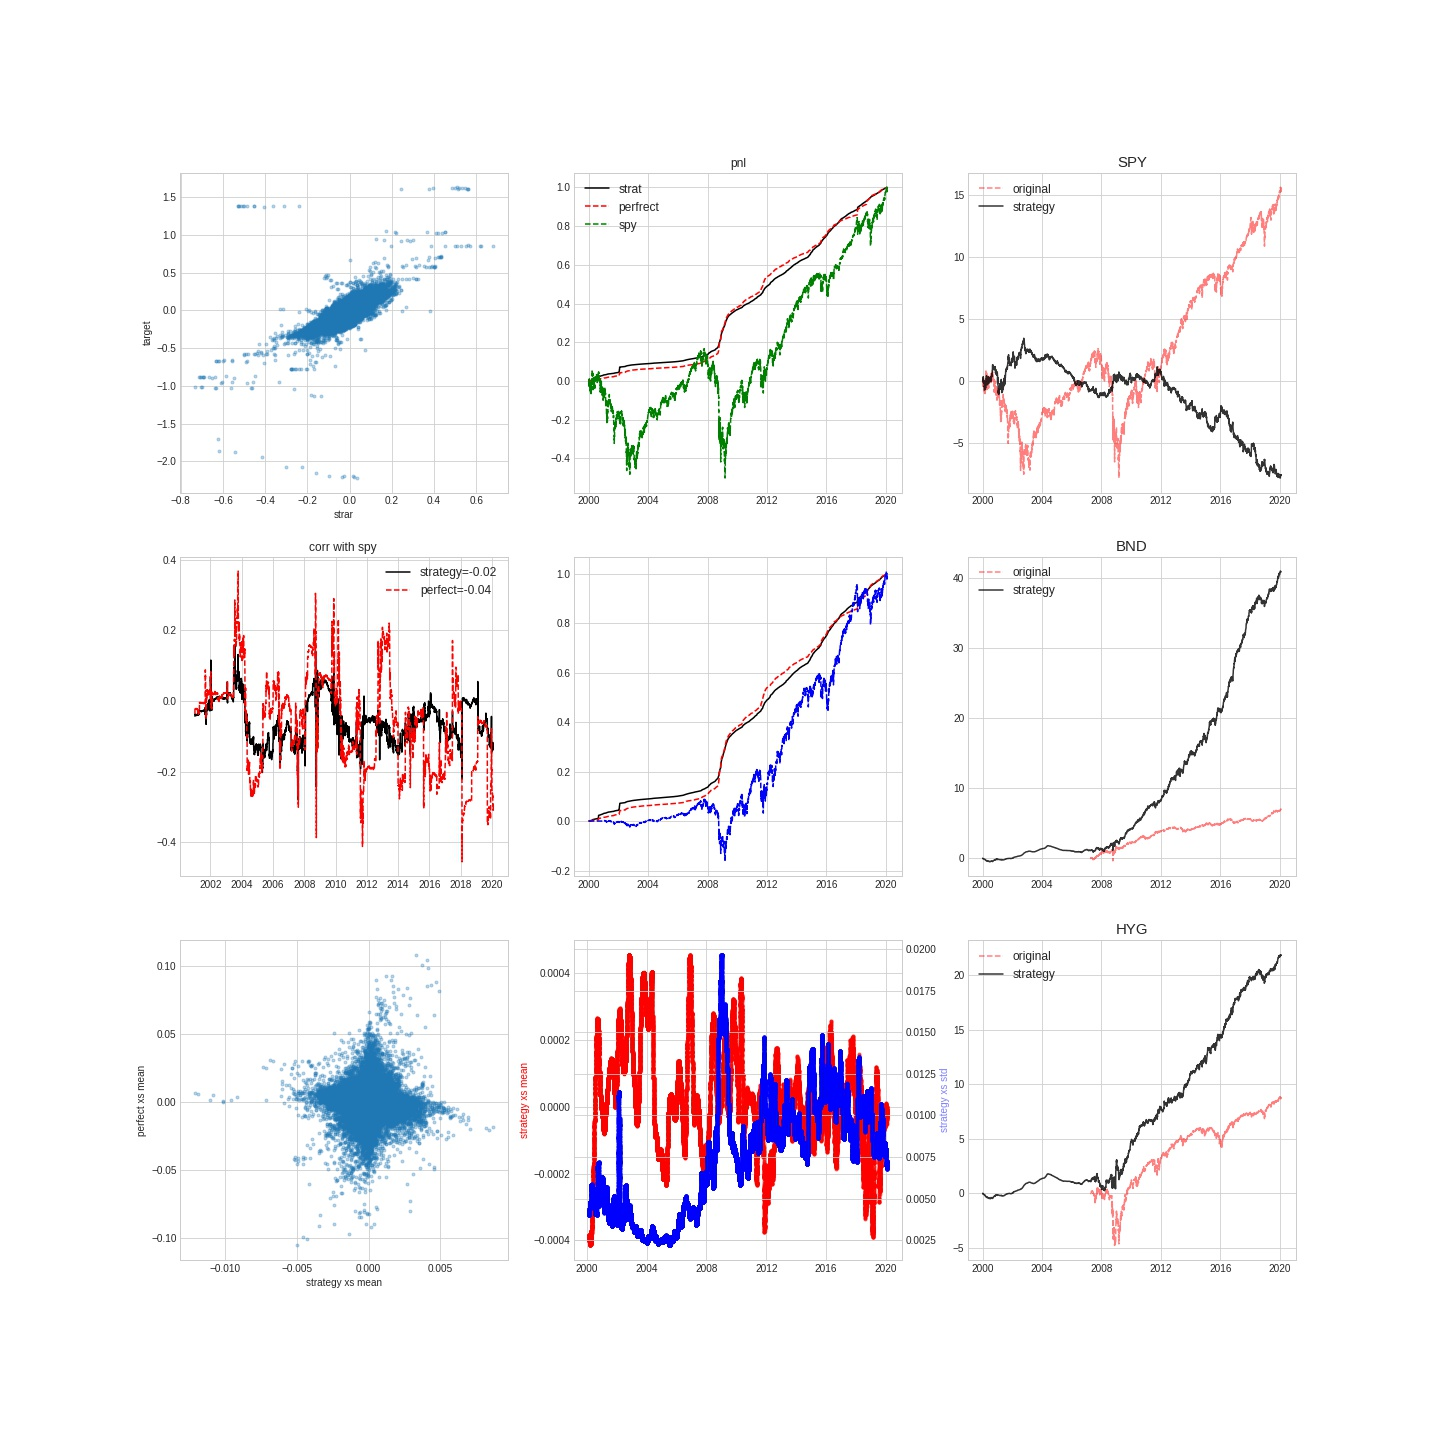

/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/fj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


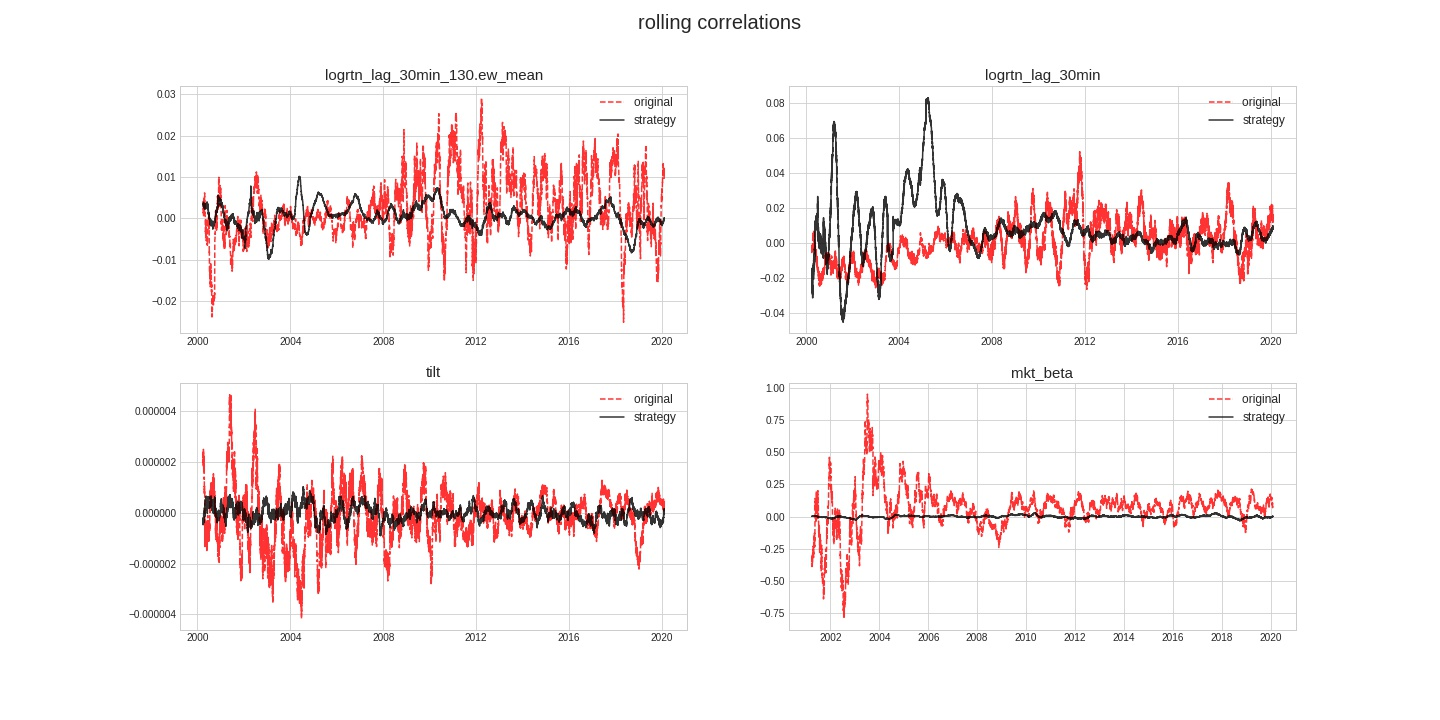

In [174]:
# returns reshaping ----
############################################
%inline
start = '20000101'

# the target returns
Y_da = da.loc[start:,:,'logrtn_lead_1day']

# compute market beta
mkt_beta = (
    ( 
        da.loc[start:,:,'logrtn_lag_1day'].fillna(0) 
        * da.loc[start:,'SPY', 'logrtn_lag_1day'].squeeze().fillna(0) 
    ).rolling(time= 13 * 252).mean() 
    / 
    (da.loc[start:,'SPY', 'logrtn_lag_1day']
     .fillna(0).squeeze().sq()
     .rolling(time= 13 * 252).mean()) 
)
mkt_rtn = (Y_da * mkt_beta).sum( dim='symbol' )

# pnl orthogonality to spy and market returns
factors_da = (da.loc[start:,['SPY'], ['logrtn_lead_1day']]
              .assign_features( mkt_rtn=mkt_rtn ))
#postiion orthogonality to mkt-beta, tilt, 10day momentum and 30min mean reversion
pfos_da = (da
           .loc[start:,:, ['logrtn_lag_30min_130.ew_mean', 'logrtn_lag_30min']]
           .assign_features( tilt=1, mkt_beta=mkt_beta ))


perfect_pnl = (Y_da*Y_da).sum( dim='symbol').to_series()
spy_pnl = factors_da.fillna(0).loc[:,'SPY','logrtn_lead_1day'].to_series() 

fig = figure( figsize=(10, 10) )
ax = subplot( 1, 1, 1)
ax.plot( mkt_rtn.to_series().cumsum() /mkt_rtn.sum(), '--r', label='market return' )
ax.plot( spy_pnl.cumsum()/spy_pnl.sum(), '-k', label='spy' )
ax.legend(fontsize=12)




mxtr = mxtr.reload()
from research.etf_technical import returns_shaper as rsp; reload(rsp)
mx.Config.start()
disp( mx.tensorboard.start( clear=True ) )
disp( mx.tensorboard.start_server() )
ss = rsp.ReturnsShaper( ).to(device, dtype)

Y = Y_da.fillna(0).to_tensor( dtype=dtype, device=device )
factors = factors_da.fillna(0).to_tensor( dtype=dtype, device=device )
pfos = pfos_da.fillna(0).to_tensor( dtype=dtype, device=device )

X = ss( Y, factors=factors, pfos=pfos )
X_da = X.to_dataarray( Y_da )


%inline

strat_pnl = (X_da*Y_da).sum( dim='symbol').to_series()

fig, axs = subplots( 3,3, figsize=(20, 20 ))
ax = axs[0][0]
ax.plot( X_da.values.reshape(-1), Y_da.values.reshape(-1), '.', alpha=0.3 )
ax.set_xlabel('strar')
ax.set_ylabel('target')

ax = axs[0][1]
ax.plot( strat_pnl.cumsum()/strat_pnl.sum(), '-k', label='strat')
ax.plot( perfect_pnl.cumsum()/perfect_pnl.sum(), '--r', label='perfrect')
ax.plot( spy_pnl.cumsum() / spy_pnl.sum(), '--g', label='spy')
ax.set_title('pnl')
ax.legend( fontsize=12 )

ax = axs[1][0]
ax.plot( strat_pnl.rolling(13*252).corr( spy_pnl ), '-k', label=f'strategy={strat_pnl.corr( spy_pnl):0.2f}' )
ax.plot( perfect_pnl.rolling(13*252).corr( spy_pnl ), '--r', label=f'perfect={perfect_pnl.corr( spy_pnl):0.2f}' )
ax.set_title('corr with spy ')
ax.legend( fontsize=12)

ax = axs[1][1]
rms = []
reg = mx.Regression( dk_lags=None, autocorr=[1, 13, 26, 52] )
rm = reg.regress( X_da, Y_da )
pnl = rm.pop('pnl')
hr = rm.pop('hitRate')
rm['name'] = 'strategy'
ax.plot(pnl.cumsum()/pnl.sum(), '-k', label='strategy' )
rms.append( rm )

rm = reg.regress( Y_da, Y_da )
pnl = rm.pop('pnl')
hr = rm.pop('hitRate')
rm['name'] = 'perfect'
ax.plot( pnl.cumsum()/pnl.sum(), '--r', label='perfect' )
rms.append( rm )

rm = reg.regress( mkt_beta, Y_da )
pnl = rm.pop('pnl')
hr = rm.pop('hitRate')
rm['name'] = 'mkt beta'
ax.plot( pnl.cumsum()/pnl.sum(), '--b', label='mkt_beta' )
rms.append( rm )

ax = axs[2][0]
ax.plot( X_da.mean(dim='symbol').values, Y_da.mean(dim='symbol').values , '.', alpha=0.3 )
ax.set_xlabel('strategy xs mean')
ax.set_ylabel('perfect xs mean')

ax = axs[2][1]
ax.plot( X_da.mean(dim='symbol').to_series().rolling(13*30).mean(), '.r', alpha=0.5 )
ax.set_ylabel('strategy xs mean', color='red')
ax = ax.twinx()
ax.plot( X_da.std(dim='symbol').to_series().rolling(13*30).mean(), '.b' )
ax.set_ylabel('strategy xs std', color='blue', alpha=0.5)


for i, sym in enumerate( ['SPY', 'BND', 'HYG'] ):
    ax = axs[i][2]
    ax.plot( Y_da.loc[:,sym].to_series().cumsum(), '--r', alpha=0.5, label=f'original' )
    ax.plot( X_da.loc[:,sym].to_series().cumsum(), '-k', alpha=0.8, label=f'strategy' )
    ax.set_title( sym, fontsize=15 )
    ax.legend(fontsize=12)
    
    
    
disp( pd.DataFrame( rms ).set_index('name') )
disp( fig )


fig = figure( figsize=(20, 10 ))
for i, pfo in enumerate( pfos_da.features.values ):
    disp( 
        f'correlation with {pfo}',
        'perfect=', ((pfos_da[:,:,i]*Y_da ).mean() /pfos_da[:,:,i].sq().mean().sqrt()/Y_da.sq().mean().sqrt() ).item(),
        'strategy=', ((pfos_da[:,:,i]*X_da ).mean() /pfos_da[:,:,i].sq().mean().sqrt()/X_da.sq().mean().sqrt() ).item(),
        )
    
    def _roll_corr( X, Y ):
        XY = (X*Y).mean( dim='symbol' ) - X.mean( dim='symbol' ) * Y.mean( dim='symbol' )
        Xs = X.std( dim='symbol')
        Ys = Y.std( dim='symbol')
        XYc =  XY / (Xs+1e-3) / (Ys +1e-3)        
        return XYc.to_series().rolling( 60 * 13 ).mean()
        
    ax = subplot( 2, 2, i+1 )
    ax.plot( _roll_corr(pfos_da[:,:,i], Y_da), '--r', alpha=0.8, label='original ')
    ax.plot( _roll_corr(pfos_da[:,:,i], X_da), '-k', alpha=0.8, label='strategy')
    ax.set_title( pfo, fontsize=15 )
    ax.legend( fontsize=12 )
fig.suptitle('rolling correlations', fontsize=20 )
disp( fig )
